# Carvana Image Masking Challenge

In [1]:
import numpy as np 
import pandas as pd

import os
import glob
import zipfile
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets,transforms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
from PIL import Image

import random

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

In [2]:
PATH = '../input/carvana-image-masking-challenge/'
PATH_WORK = '/kaggle/working/'
TRAIN = 'train.zip'
TRAIN_MASK = 'train_masks.zip'
IMAGE_SIZE = 256
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
EPOCH = 30

## Первичная предобработка данных

Разделим данные на тренировчную и тестовую выборки. 

In [3]:
def data_spliter(path=PATH):   
    dirs = [TRAIN, TRAIN_MASK]
    for x in dirs:
        with zipfile.ZipFile(PATH + x,'r') as z:
            z.extractall('.')
        
    images = sorted(os.listdir('./' + TRAIN.split('.')[0]))
    masks = sorted(os.listdir('./' + TRAIN_MASK.split('.')[0]))

    df = pd.DataFrame({'masks' : masks,
                       'images' : images})

    features_train, features_valid, target_train, target_valid = train_test_split(
        df['images'],df['masks'],
        train_size=.75,random_state=42
    )

    return features_train, features_valid, target_train, target_valid

In [4]:
features_train, features_valid, target_train, target_valid = data_spliter()

Определим класс для чтения данных.

In [5]:
class CarvanaDataset(torch.utils.data.Dataset):
    
    def __init__(self, path, images, masks, transform=None):
        
        self.path_image = path + TRAIN.split('.')[0]
        self.path_mask = path + TRAIN_MASK.split('.')[0]

        self.images = list(images)
        self.masks = list(masks)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.masks)
    
    def __getitem__(self, index):
        
        image_path = os.path.join(self.path_image, self.images[index])
        mask_path = os.path.join(self.path_mask, self.masks[index])
        
        image = np.array(Image.open(image_path).convert('RGB'), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        
        mask /= 255
        
        # augmentation
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        return image, mask

Расчитаем среднее и среднеквадратичное отклонение для последующей нормализации изображений.

In [6]:
# stat_transform = A.Compose([
#     A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
#     A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
#     ToTensorV2()
# ])

In [7]:
# stat_dataset = CarvanaDataset(PATH_WORK, features_train, target_train, transform=stat_transform)
# stat_dataloader = torch.utils.data.DataLoader(stat_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# psum = torch.tensor([0.0, 0.0, 0.0])
# psum_sq = torch.tensor([0.0, 0.0, 0.0])

# for images, _ in tqdm(stat_dataloader):
#     psum += images.sum(axis=[0, 2, 3])
#     psum_sq += (images ** 2).sum(axis=[0, 2, 3])

In [9]:
# count = len(features_train) * IMAGE_SIZE * IMAGE_SIZE

# total_mean = psum / count
# total_var  = (psum_sq / count) - (total_mean ** 2)
# total_std  = torch.sqrt(total_var)

# mean = total_mean.tolist()
# std = total_std.tolist()

# print(f'mean: {mean}')
# print(f'std: {std}')

In [10]:
mean = [0.6982, 0.6912, 0.6841]
std = [0.2440, 0.2479, 0.2449]

Определим методы аугментации и преобразования изображений.

In [11]:
train_transform = A.Compose([
    A.CenterCrop(p=0.5, height=1000, width=1000),
    A.GaussianBlur(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

valid_test_transform = A.Compose([
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

In [12]:
train_dataset = CarvanaDataset(PATH_WORK, features_train, target_train, transform=train_transform)
valid_dataset = CarvanaDataset(PATH_WORK, features_valid, target_valid, transform=valid_test_transform)

In [13]:
print('Image shape:\n{}\n'.format(train_dataset[0][0].shape))
print('Mask shape:\n{}'.format(train_dataset[0][1].shape)) 

Image shape:
torch.Size([3, 256, 256])

Mask shape:
torch.Size([256, 256])


In [14]:
print('Train dataset length:', train_dataset.__len__())
print('Valid dataset length:', valid_dataset.__len__())

Train dataset length: 3816
Valid dataset length: 1272


In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

Выведем несколько изобажений из тренировочной выборки.

In [16]:
def image_show_tensor(dataloader, number_of_images=7, initial_index=0):
    
    images, masks = next(iter(dataloader))

    fig = plt.figure(figsize=(20, 20))
    
    for tensor in [images, masks]:
        
        if tensor is masks:
            tensor = tensor.numpy()
        else:
            tensor = tensor.numpy().transpose(0,2,3,1)
            tensor = std * tensor + mean
        
        fig = plt.figure(figsize=(20, 20))
        
        for i in range(number_of_images):

            fig.add_subplot(1, number_of_images+1, i+1)
            plt.imshow(tensor[i+initial_index], cmap='viridis')

            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            
    plt.show()

<Figure size 1440x1440 with 0 Axes>

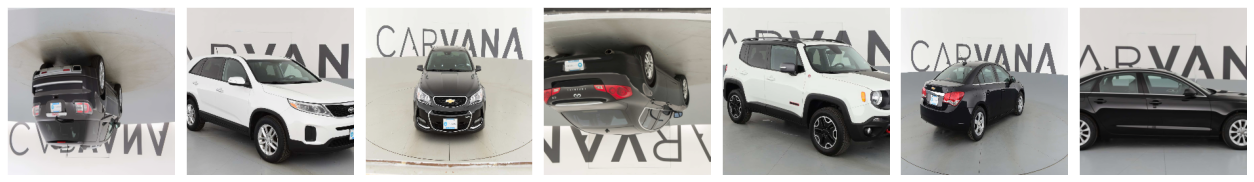

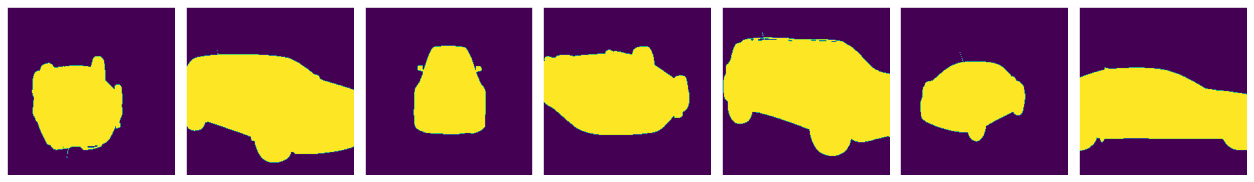

In [17]:
image_show_tensor(train_dataloader)

## Model

Определим модель на основе **Unet** для решения задачи сегментации.

In [18]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [19]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear)        
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
unet = UNet(3, 1).to(device, dtype=torch.float)

В качестве функции потерь будем использовать **бинарную кросс-энтропию**.

In [22]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

Дополнительно будем высчитывать **Dice Coefficient**.

In [23]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [24]:
%%time

train_loss_history, valid_loss_history = [], []
train_dice_history, valid_dice_history = [], []

for epoch in range(EPOCH):
    
    train_batch_loss_history, valid_batch_loss_history = [], []
    train_batch_dice_history, valid_batch_dice_history = [], []
    
    unet.train()
    for image, mask in train_dataloader:
        
        optimizer.zero_grad()
        
        mask = mask.view(len(mask), 1, IMAGE_SIZE, IMAGE_SIZE)
        mask = mask.to(device, dtype=torch.float)
        image = image.to(device, dtype=torch.float)
        
        pred = unet(image)
        loss_train = loss(pred, mask)
        # dice
        pred = np.copy(pred.data.cpu().numpy())
        pred[np.nonzero(pred < 0.5)] = 0.0
        pred[np.nonzero(pred >= 0.5)] = 1.0

        train_dice = dice_coef_metric(pred, mask.data.cpu().numpy())
        train_batch_dice_history.append(train_dice)
        train_batch_loss_history.append(loss_train.item())
        
        loss_train.backward()
        optimizer.step()
        
        del mask, image
        torch.cuda.empty_cache()
    
    unet.eval()
    for image, mask in valid_dataloader:
                
        mask = mask.view(len(mask), 1, IMAGE_SIZE, IMAGE_SIZE)
        mask = mask.to(device,dtype=torch.float)
        image = image.to(device,dtype=torch.float)
                
        pred_valid = unet(image)
        loss_valid = loss(pred_valid, mask)
        # dice
        pred_valid = np.copy(pred_valid.data.cpu().numpy())
        pred_valid[np.nonzero(pred_valid < 0.5)] = 0.0
        pred_valid[np.nonzero(pred_valid >= 0.5)] = 1.0

        valid_dice = dice_coef_metric(pred_valid, mask.data.cpu().numpy())
        valid_batch_dice_history.append(valid_dice)
        valid_batch_loss_history.append(loss_valid.item())
        
        del mask, image
        torch.cuda.empty_cache()
                
    train_loss = np.mean(train_batch_loss_history)
    train_loss_history.append(train_loss)
    train_dice = np.mean(train_batch_dice_history)
    train_dice_history.append(train_dice)
    
    valid_loss = np.mean(valid_batch_loss_history)                          
    valid_loss_history.append(valid_loss)
    valid_dice = np.mean(valid_batch_dice_history)                          
    valid_dice_history.append(valid_dice)

    print('{:4d} | train_loss:{:.4f} | valid_loss:{:.4f} | Dice_train:{:.4f} | Dice_valid:{:.4f}'.format(epoch,
                                                                                                         train_loss, valid_loss,
                                                                                                         train_dice, valid_dice))

   0 | train_loss:0.1286 | valid_loss:0.0539 | Dice_train:0.9284 | Dice_valid:0.9513
   1 | train_loss:0.0484 | valid_loss:0.0250 | Dice_train:0.9711 | Dice_valid:0.9781
   2 | train_loss:0.0388 | valid_loss:0.1159 | Dice_train:0.9768 | Dice_valid:0.8791
   3 | train_loss:0.0408 | valid_loss:0.0204 | Dice_train:0.9762 | Dice_valid:0.9814
   4 | train_loss:0.0219 | valid_loss:0.0161 | Dice_train:0.9869 | Dice_valid:0.9856
   5 | train_loss:0.0438 | valid_loss:0.0152 | Dice_train:0.9740 | Dice_valid:0.9860
   6 | train_loss:0.0222 | valid_loss:0.0146 | Dice_train:0.9867 | Dice_valid:0.9868
   7 | train_loss:0.0217 | valid_loss:0.0126 | Dice_train:0.9872 | Dice_valid:0.9886
   8 | train_loss:0.0174 | valid_loss:0.0129 | Dice_train:0.9896 | Dice_valid:0.9881
   9 | train_loss:0.0243 | valid_loss:0.0130 | Dice_train:0.9852 | Dice_valid:0.9880
  10 | train_loss:0.0222 | valid_loss:0.5030 | Dice_train:0.9869 | Dice_valid:0.8770
  11 | train_loss:0.0176 | valid_loss:0.0109 | Dice_train:0.9895 

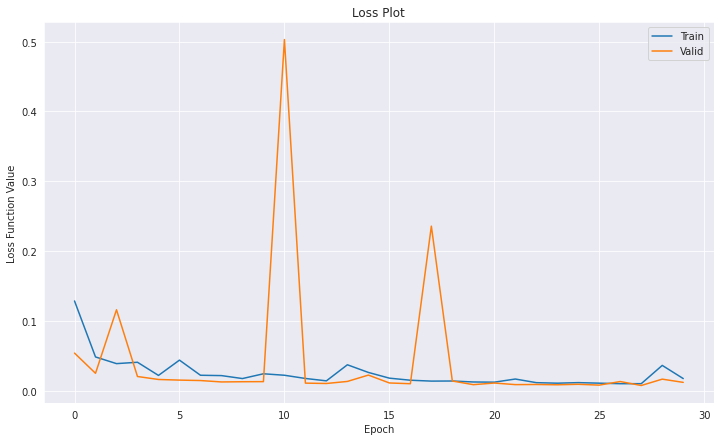

In [25]:
plt.subplots(figsize=(12, 7))

plt.plot(train_loss_history, label='Train')
plt.plot(valid_loss_history, label='Valid')

plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend()

plt.show()

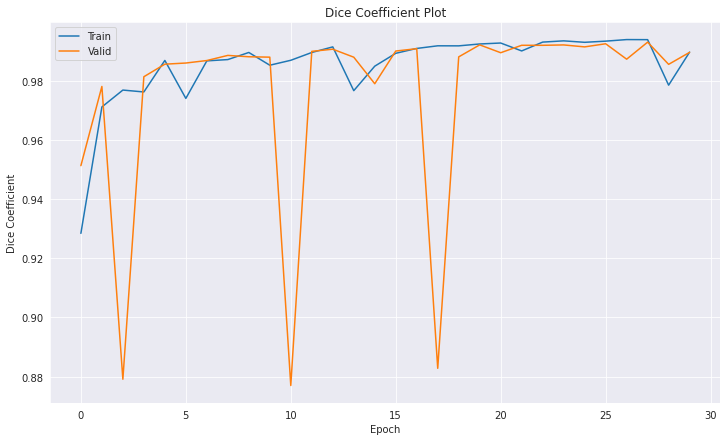

In [26]:
plt.subplots(figsize=(12, 7))

plt.plot(train_dice_history, label='Train')
plt.plot(valid_dice_history, label='Valid')

plt.title('Dice Coefficient Plot')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()

Визуально оценим качество выполняемой сегементации. 

In [27]:
def singular_result(dataloader, model=unet, initial_index=0, cmap='viridis'):
    
    model.eval()
    images, masks = next(iter(dataloader))
    masks = masks.view(len(masks), 1, IMAGE_SIZE, IMAGE_SIZE)

    prediction = model(images.to(device,dtype=torch.float))
    filtred = (prediction>0.5).float()

    tensors = [images, masks, prediction, filtred]
    titles = ['Image', 'Mask', 'Prediction', 'Filtred Prediction']
    
    f, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]):
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if tensor.shape[-1] == 1:     
            ax[i, j].imshow(tensor[initial_index], cmap=cmap)  
        else:
            tensor = std * tensor + mean
            ax[i, j].imshow(tensor[initial_index])
            
        ax[i, j].set_title(title)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
    plt.show()

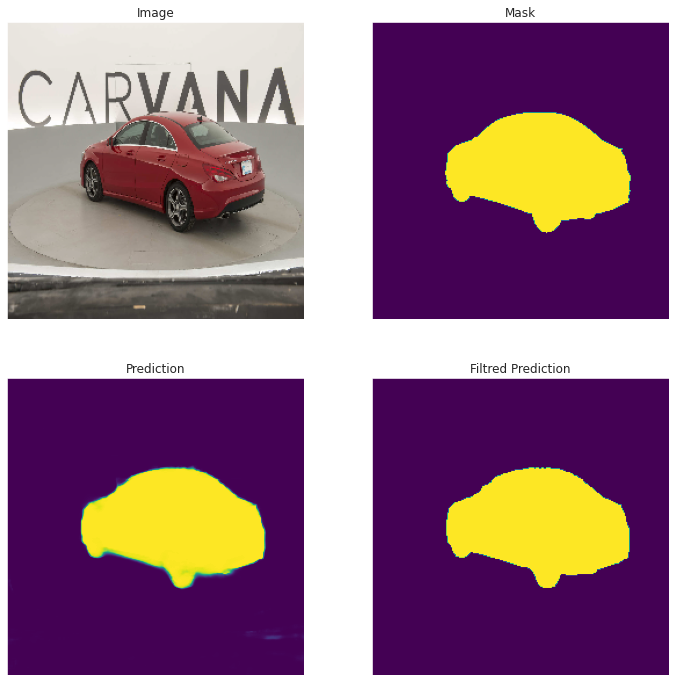

In [28]:
singular_result(valid_dataloader)

## Вывод

Исходные данные, общий объем которых составил **5088** изображений с соответствующими им масками, были разделены в соотношение **3:1** на тренировочную и тестовую выборки. После предобработки данных изображения были привидены к размеру **256x256** пикселей.

Для решения данной задачи использовалась сеть на основе архитектуры **Unet** с алгоритмом оптимизации **Adam** и функцией потерь бинарной кросс-энтропией. Обучение проводилось в течение **30-ти** эпох. На последней эпохе показатель функции потерь составил - **0.0077**, а значение метркии **Dice Coefficient** равняется **0.9928** для валидационной выборки. 